In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch, torchvision
from PIL import Image
%matplotlib inline

In [2]:
# configuration
imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
imagenet_std  = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
# these are good weights settings
style_weights = [1e3/n**2 for n in [64, 128, 256, 512, 512]]
content_weights = [1e0]

In [3]:
# parameters
image_size = [400, 300]    # MX150's memory is too small
style_layers, content_layers   = [1, 6, 11, 20, 25], [21]
style_file, content_file   = "vangogh_starry_night.jpg", "house.png"
device = torch.device('cuda') #cpu
epochs, print_interval = 500, 50

In [4]:
# VGG-19 were trained using Caffe, the latter uses OpenCV to load images which uses BGR by default
image_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.Resize(image_size[::-1]),      # torchvision use (height, width)
    torchvision.transforms.ToTensor(),                    # turn to BGR
    torchvision.transforms.Lambda(lambda x: (x - imagenet_mean)/imagenet_std),
    torchvision.transforms.Lambda(lambda x: x*255),
    torchvision.transforms.Lambda(lambda x: x[[2, 1, 0]]),
])

tensor_to_image = torchvision.transforms.Compose([
    torchvision.transforms.Lambda(lambda x: x[[2, 1, 0]]), #turn to RGB
    torchvision.transforms.Lambda(lambda x: x/255),
    torchvision.transforms.Lambda(lambda x: x*imagenet_std + imagenet_mean),
    torchvision.transforms.Lambda(lambda x: x.clamp(0, 1)),
    torchvision.transforms.ToPILImage()
])

In [5]:
style_image   = image_to_tensor(Image.open(f"images/{style_file}"  )).unsqueeze(0).to(device)
content_image = image_to_tensor(Image.open(f"images/{content_file}")).unsqueeze(0).to(device)
output_image  = content_image.clone().detach().requires_grad_()  

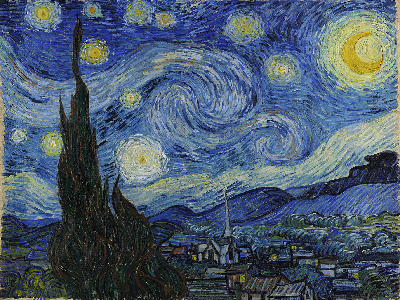

In [6]:
Image.open(f"images/{style_file}"  ).resize(image_size)

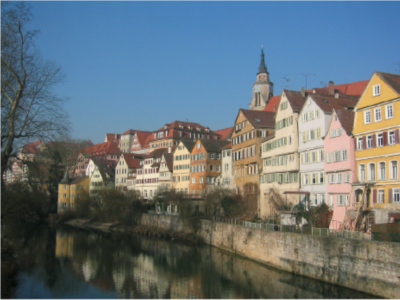

In [7]:
tensor_to_image(content_image[0].cpu())

In [8]:
class LayerActivations():
    def __init__(self, model, layer_nums):
        self.handles  = []
        self.features = []  
        for layer_num in layer_nums:
            self.handles.append(model[layer_num].register_forward_hook(self.hook))
    
    def hook(self, module, input, output):
        self.features.append(output)
    
    def remove(self):
        for handle in self.handles: handle.remove()

def extract_layers(model, inputs, layer_nums):
    la = LayerActivations(model, layer_nums)
    model(inputs)
    la.remove()
    return la.features

def gram_matrix(inputs):
        batch, channel, height, width = inputs.size()
        features = inputs.view(batch, channel, height*width)
        G = torch.bmm(features, features.transpose(1,2))
        return G.div(height*width)  # gram_matrix should be normalized by batch*channel*height*width, but batch is constant (1), channel is already incubed style_weights

def get_contents_l(model, inputs, layer_nums):
    return extract_layers(model, inputs, layer_nums)

def get_styles_l(model, inputs, layer_nums):
    return [gram_matrix(x) for x in extract_layers(model, inputs, layer_nums)]

In [9]:
vgg = torchvision.models.vgg19(pretrained = True).features.cuda()
for param in vgg.parameters(): param.requires_grad_(False)
    
optimizer = torch.optim.LBFGS([output_image])
criterion = torch.nn.MSELoss()

In [10]:
target_contents_l = get_contents_l(vgg, content_image, content_layers)
target_styles_l   = get_styles_l(  vgg, style_image,   style_layers)

run = [0]
while run[0] <= epochs:
    def closure():
        optimizer.zero_grad()    
        output_contents_l = get_contents_l(vgg, output_image, content_layers)
        output_styles_l   = get_styles_l(  vgg, output_image, style_layers)
        content_loss_l  = [w*criterion(o, t) for w, o ,t in zip(content_weights, output_contents_l, target_contents_l)]
        style_loss_l    = [w*criterion(o, t) for w, o ,t in zip(style_weights,   output_styles_l, target_styles_l)]
        loss = sum(content_loss_l) + sum(style_loss_l)
        loss.backward()
        run[0]+=1
        if run[0] % print_interval == 0: 
            print(f'Iteration{run[0]:03d}, loss: {loss.item():10.2f}')
            tensor_to_image(output_image[0].cpu()).save('output/style-transfer.png')
        return  loss
    optimizer.step(closure)

Iteration050, loss: 1648677.12
Iteration100, loss:  696433.94
Iteration150, loss:  487063.38
Iteration200, loss:  408659.00
Iteration250, loss:  368357.16
Iteration300, loss:  343877.25
Iteration350, loss:  327927.19
Iteration400, loss:  316407.25
Iteration450, loss:  307590.66
Iteration500, loss:  300872.75


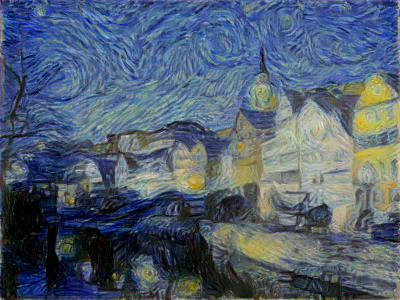

In [11]:
Image.open("output/style-transfer.png").resize(image_size)